# Radiative Heat Transfer - Spherical P1 Model
# One-Dimensional - Finite Differences - Uniform Mesh  
Goal: To study P1 radiation model and gain understanding of how volumetric absorption coefficient $a$ and wall emissivity influence the total incident radiation $G$, the $a \, G$ contribution to the divergence of the radiative heat flux and the total divergence of the radiative flux. We assume
1. the furnace (cement kiln) to be one-dimensional (along its main axis);  
2. temperature as computed by [Pisaroni-2012](https://link.springer.com/article/10.1186/2190-5983-2-3); 

## Section 1: Introduction 

### Nomenclature - Units 

Total incident radiation 
$G(\mathbf{r},\mathbf{s}) = \int_0^{2 \, \pi} I(\mathbf{r},\mathbf{s}) \, \mathbf{n} \cdot \mathbf{s} \, d\Omega$ in W/m$^2$. P1 model makes spherical approximation. 

Absorption coefficient $a$ in 1/m. Assume no scattering. Then parameter (diffusion constant in P1 radiation model) $\Gamma = \frac{1}{3\,a}$ in m. 

Wall emissivity value $\epsilon_w$ where $0 <= \epsilon_w <= 1$. 

Volumetric radiative flux $q_r(\mathbf{r}) = - \Gamma \, \nabla G(\mathbf{r})$ in W/m^2.


### Boundary Value Problem 

Solves the P1-model for the total incident radiation 

$\frac{d}{dx} \left[ \frac{1}{3\,a} \frac{d \, G}{dx} \right] - a \, G = - 4 \, a \, \sigma \, T^4$ 

on the 1D domain $\Omega=(0,x_{max})$ supplied with Marshak boundary condition

$\frac{1}{3\,a} \frac{d \, G}{dn} = - q_{r,w} = 
 \frac{\epsilon_w}{2 \, (2 - \epsilon_w)} \, [ 4 \, \sigma \, T_w^4 - G_w ]$, 
 
where underscore $w$ denotes the wall values. Discuss various values of $\epsilon_w$. For $\epsilon_w=0$, symmetry conditions for $G$ are obtained. $G$ is expected to change gradually only. For $\epsilon_w=1$, black body conditions for $G$ are imposed. 

### Coupling with the energy equation 

Having solved for $G$, the divergence of the radiative flux can be computed as 

$\nabla \cdot q_r = 4 \, a \, \sigma \, T^4 - a \, G$ in W/m^3. 

### Implementation in OpenFoam

Refer to student report under supervision of Hakon Nilsson (provide link here)

### References 

1. Fluent Manual 
2. OpenFoam Resources 
3. Book by Modest e.a. 

## Import Packages

In [5]:
using LinearAlgebra
using NLsolve
using SparseArrays
using Plots
using LaTeXStrings
using BenchmarkTools 

## Section 2: Solve Energy Equation for Temperature

We define a 1D diffusion equation that reproduces the axial temperature profile in Figure-7 of [Pisaroni-2012](https://link.springer.com/article/10.1186/2190-5983-2-3), red coloured line, converted from Celcius to Kelin. (heat transfer coefficient assumed equal one in appropriate units).

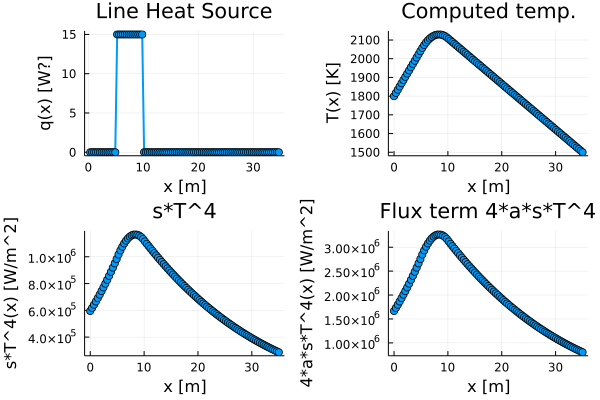

In [92]:
# set Stefan - Boltzman constant 
sigma = 5.67 * 1e-8 # [W/(m^2 K^4)]

#..set absorption coefficient a, the diffusion coefficient Gamma = 1/a, 
#..the wall emissivity value, left wall temperature and right wall temperature  
a = 0.7 # [1/m] Value communicated by Pisaroni 
Gamma = 1/a 
emissivityw = 1
Twl = 1800 # [K]
Twr = 1500 # [K]

#..construct the 1D mesh
xmax = 35
N = 100; Np1 = N+1; h = xmax/N; h2=h*h; 
x = Vector(0:h:xmax); 

#..construct the source function for temperature
q = 15 .* ((x.>=5).*(x.<=10)); 
if false 
  plot(x,q)
end 

#..construct the coefficient matrix with our the boundary conditions 
e = ones(Np1); #..note that ones(N+1,1) does *not* work here 
A = Tridiagonal(-e[2:end], 2*e, -e[2:end]); 
A = (1/h2)*A; 

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;          A[1,2] = 0;          q[1] = Twl; 
A[end,end-1]=0;      A[end,end] = 1;      q[end] = Twr;  
    
#..solve the linear system
T = A \ q; 

#..plot the solution  
p1=plot(x[2:end-1],q[2:end-1],shape=:circle,lw=2,legend=false)
xlabel!("x [m]") 
ylabel!("q(x) [W?]")
title!("Line Heat Source")

p2=plot(x,T,shape=:circle,lw=2,legend=false)
xlabel!("x [m]") 
ylabel!("T(x) [K]")
title!("Computed temp.")

p3=plot(x,sigma*T.^4,shape=:circle,lw=2,legend=false)
xlabel!("x [m]") 
ylabel!("s*T^4(x) [W/m^2]")
title!("s*T^4")

p4=plot(x,4*a*sigma*T.^4,shape=:circle,lw=2,legend=false)
xlabel!("x [m]") 
ylabel!("4*a*s*T^4(x) [W/m^2]")
title!("Flux term 4*a*s*T^4")

plot(p1,p2,p3,p4,layout=(2,2))

## Section 3: Solve P1 Model for Total Incident Radiation G and Post-Process for the Radiative Heat  Flux 

We result for the radiative heat flux compares reasonably well (given the limitations of the 1D model) with Figure-10 of [Pisaroni-2012](https://link.springer.com/article/10.1186/2190-5983-2-3), green line. 

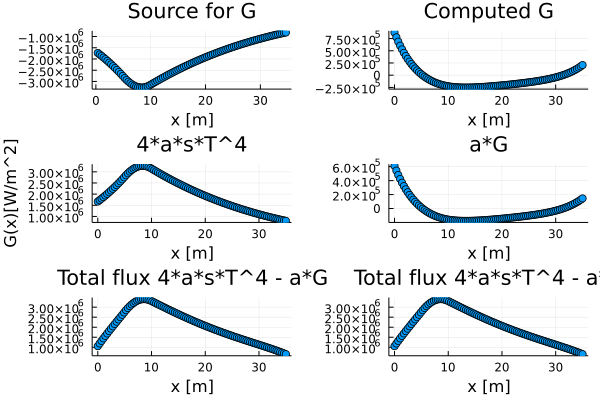

In [94]:
#..construct the coefficient matrix with our the boundary conditions 
e = ones(Np1); #..note that ones(N+1,1) does *not* work here 
S = Tridiagonal(-e[2:end], 2*e, -e[2:end]); 
S = (1/h2)*A; 
M = Diagonal(e); 
A = Gamma*S+a*M; #..A always has a positive diagonal  

f = -4*a*sigma*T.^4; #..beware of the minus sign.. 

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = -Gamma;          A[1,2] = Gamma;          
A[1,1] += emissivityw/(2*(2-emissivityw))
f[1] = emissivityw/(2*(2-emissivityw))*sigma*Twl.^4;
A[end,end-1]=-Gamma;      A[end,end] = Gamma;      
A[end,end] += emissivityw/(2*(2-emissivityw))
f[end] = emissivityw/(2*(2-emissivityw))*sigma*Twr.^4;

#..solve the linear system
u = A \ f; 

#..plot stuff   
p1=plot(x[2:end-1],f[2:end-1],shape=:circle,lw=2,legend=false)
xlabel!("x [m]") 
title!("Source for G")

p2=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x [m]") 
title!("Computed G")

p3=plot(x,4*a*sigma*T.^4,shape=:circle,lw=2,legend=false)
xlabel!("x [m]") 
ylabel!("G(x)[W/m^2]")
title!("4*a*s*T^4")

p4=plot(x,a*u,shape=:circle,lw=2,legend=false)
xlabel!("x [m]") 
title!("a*G")

p5=plot(x,4*a*sigma*T.^4 - a*u,shape=:circle,lw=2,legend=false)
xlabel!("x [m]") 
title!("Total flux 4*a*s*T^4 - a*G")

plot(p1,p2,p3,p4,p5,p5,layout=(3,2))
